# Advancing Search Capabilities: From Lexical to Multi-Modal with Deep Lake

Install the main libraries

In [2]:
!pip install deeplake


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


## Load the Data from Deep Lake

The following code opens the dataset in read-only mode from Deep Lake at the specified path `al://activeloop/restaurant_dataset_complete`. The `scraped_data` object now contains the complete restaurant dataset, featuring 160 restaurants and over 24,000 images, ready for data extraction and processing.

In [3]:
import deeplake
scraped_data = deeplake.open_read_only(f"al://activeloop/restaurant_reviews_complete")

In [ ]:
print(f"Scraped {len(scraped_data)} reviews")

Scraped 18625 restaurants


## 1) Create the Dataset and Use an Inverted Index for Filtering

In the first stage of this course, we’ll cover Lexical Search, a traditional and foundational approach to information retrieval.

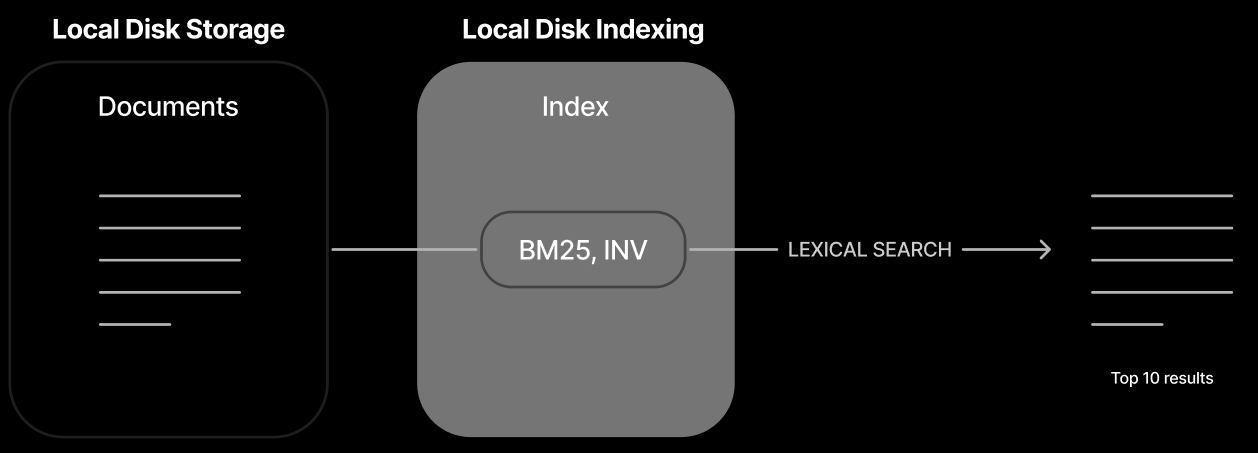

An inverted index is a data structure commonly used in search engines and databases to facilitate fast full-text searches. Unlike a row-wise search, which scans each row of a document or dataset for a search term, an inverted index maps each unique word or term to the locations (such as document IDs or row numbers) where it appears. This setup allows for very efficient retrieval of information, especially in large datasets.

For small datasets with up to 1,000 documents, row-wise search can provide efficient performance without needing an inverted index. For medium-sized datasets (10,000+ documents), inverted indexes become useful, particularly if search queries are frequent. For large datasets of 100,000+ documents, using an inverted index is essential to ensure efficient query processing and meet performance expectations.

In [12]:
import deeplake
from deeplake import types

# Create a dataset
inverted_index_dataset = "local_inverted_index"
ds = deeplake.create(f"file://{inverted_index_dataset}")

We now create two columns in the dataset: `restaurant_name` and `restaurant_review`. Both columns are text-based and use an inverted index to improve search efficiency.

In [13]:
ds.add_column("restaurant_name", types.Text(index_type=types.Inverted))
ds.add_column("restaurant_review", types.Text(index_type=types.Inverted))
ds.add_column("owner_answer", types.Text(index_type=types.Inverted))

### Extract the data


This code extracts restaurant details from `scraped_data` into separate lists: 
1. **Initialize Lists** : `restaurant_name`, `restaurant_review` and `owner_answer` are initialized to store respective data for each restaurant.
 
2. **Populate Lists** : For each entry (`el`) in `scraped_data`, the code appends: 
  - `el['restaurant_name']` to `restaurant_name`
 
  - `el['restaurant_review']` to `restaurant_review`
 
  - `el['owner_answer']` to `owner_answer`

After running, each list holds a specific field from all restaurants, ready for further processing.


In [14]:
restaurant_name = []
restaurant_review = []
owner_answer = []
images = []
for el in scraped_data:
    restaurant_name.append(el['restaurant_name'])
    restaurant_review.append(el['restaurant_review'])
    owner_answer.append(el['owner_answer'])

### Add the data to the dataset

We add the collected restaurant names and reviews to the dataset `ds`. Using `ds.append()`, we insert two columns: `"restaurant_name"` and `"restaurant_review"`, populated with the values from our lists `restaurant_name` and `restaurant_review`. After appending the data, `ds.commit()` saves the changes permanently to the dataset, ensuring all new entries are stored and ready for further processing.

In [15]:
ds.append({
    "restaurant_name": restaurant_name,
    "restaurant_review": restaurant_review,
    "owner_answer": owner_answer
})
ds.commit()

In [16]:
ds

Dataset(columns=(restaurant_name,restaurant_review,owner_answer), length=18625)

### Search for the restaurant using a specific word

We define a search query to find any entries in the dataset `ds` where the word `"tapas"` appears in the `restaurant_review` column. The command `ds.query()` runs a TQL query with `SELECT *`, which retrieves all entries that match the condition `CONTAINS(restaurant_review, '{word}')`. This search filters the dataset to show only records containing the specified word (`tapas`) in their reviews. The results are saved in the variable `view`.

Deep Lake offers a high-performance SQL-based query engine for data analysis called `TQL` (Tensor Query Language). You can find the official documentation [here](https://docs.deeplake.ai/latest/guide/tql/).

In [22]:
word = 'burritos'
view = ds.query(f"""
    SELECT * 
    WHERE CONTAINS(restaurant_review, '{word}')
    LIMIT 4
""")
view

Dataset(columns=(restaurant_name,restaurant_review,owner_answer), length=4)

### Show the results

In [23]:
for row in view:
    print(f"Restaurant name: {row['restaurant_name']} \nReview: {row['restaurant_review']}")

Restaurant name: Los Amigos 
Review: Best Burritos i have ever tried!!!!! Wolderful!!!
Restaurant name: Los Amigos 
Review: Really good breakfast burrito, and just burritos in general
Restaurant name: Los Amigos 
Review: Ordered two of their veggie burritos, nothing crazy just added extra cheese and sour cream. They even repeated the order back to me and everything was fine, then when I picked the burritos up and got home they put zucchini and squash in it.. like what??
Restaurant name: Los Amigos 
Review: Don't make my mistake and over order. The portions are monstrous. The wet burritos are as big as a football.


AI data retrieval systems today face 3 challenges: `limited modalities`, `lack of accuracy`, and `high costs at scale`. Deep Lake 4.0 fixes this by enabling true multi-modality, enhancing accuracy, and reducing query costs by 2x with index-on-the-lake technology.

Consider a scenario where we store all our data locally on a computer. Initially, this may be adequate, but as the volume of data grows, managing it becomes increasingly challenging. The computer’s storage becomes limited, data access slows, and sharing information with others is less efficient.

To address these challenges, we can transition our data storage to the cloud using Deep Lake. Designed specifically for handling large-scale datasets and AI workloads, Deep Lake enables up to 10 times faster data access. With cloud storage, hardware limitations are no longer a concern: Deep Lake offers ample storage capacity, secure access from any location, and streamlined data sharing.

This approach provides a robust and scalable infrastructure that can grow alongside our projects, minimizing the need for frequent hardware upgrades and ensuring efficient data management.

## 2) Create the Dataset and use BM25 to Retrieve the Data

Our advanced `"Index-On-The-Lake"` technology enables sub-second query performance directly from object storage, such as `S3`, using minimal compute power and memory resources. Achieve up to `10x greater cost efficiency` compared to in-memory databases and `2x faster performance` than other object storage solutions, all without requiring additional disk-based caching.

With Deep Lake, you benefit from rapid streaming columnar access to train deep learning models directly, while also executing sub-second indexed queries for retrieval-augmented generation.

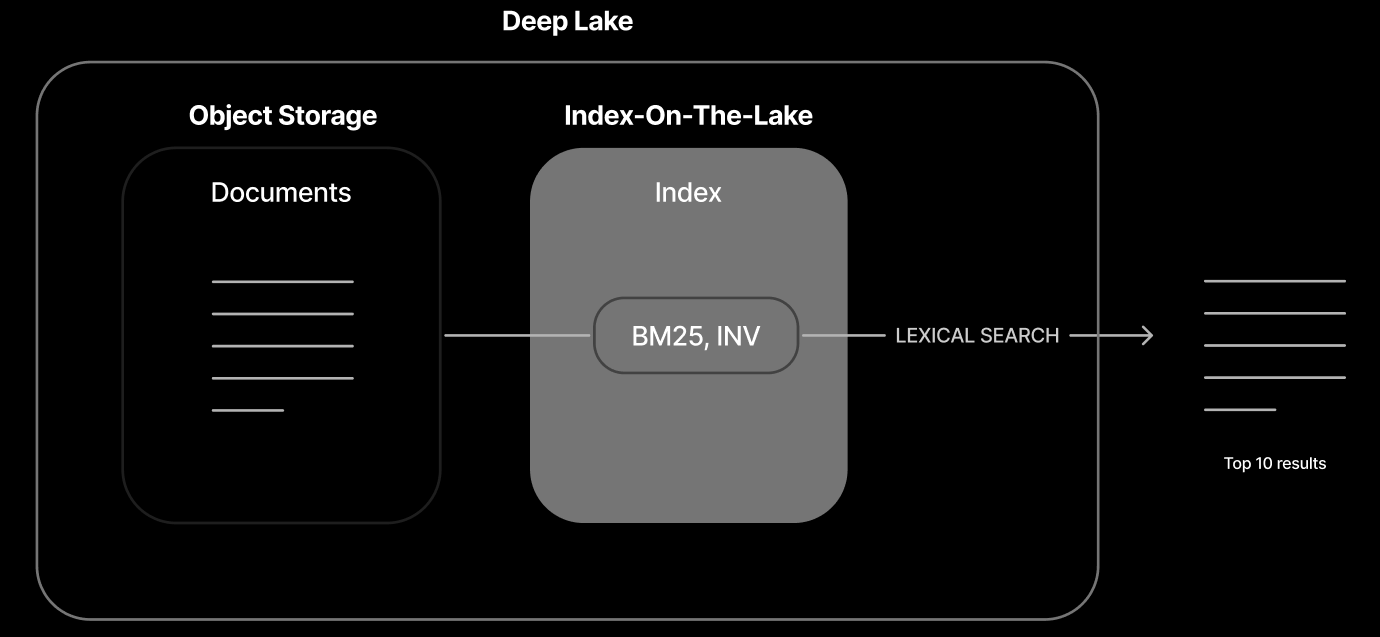

In this stage, the system uses BM25 for a straightforward lexical search. This approach is efficient for retrieving documents based on exact or partial keyword matches.


We start by importing deeplake and setting up an organization ID `org_id` and dataset name `dataset_name_bm25`. Next, we create a new dataset with the specified name and location in Deep Lake storage.

We then add two columns to the dataset: `restaurant_name` and `restaurant_review`. Both columns use a BM25 index, which optimizes them for relevance-based searches, enhancing the ability to rank results based on how well they match search terms.

Finally, we use `ds_bm25.commit()` to save these changes to the dataset and `ds_bm25.summary()` to display an overview of the dataset's structure and contents.

If you don't have a token yet, you can sign up and then log in on the official [Activeloop website](https://app.activeloop.ai/), then click the `Create API token` button to obtain a new API token. Here, under `Select organization`, you can also find your organization ID(s).

In [1]:
import os, getpass
os.environ["ACTIVELOOP_TOKEN"] = getpass.getpass("Activeloop API token: ")

In [ ]:
org_id = "<your_org_id>" 
dataset_name_bm25 = "bm25_test"

ds_bm25 = deeplake.create(f"al://{org_id}/{dataset_name_bm25}")

In [27]:
# Add columns to the dataset
ds_bm25.add_column("restaurant_name", types.Text(index_type=types.BM25))
ds_bm25.add_column("restaurant_review", types.Text(index_type=types.BM25))
ds_bm25.add_column("owner_answer", types.Text(index_type=types.BM25))
ds_bm25.commit()
ds_bm25.summary()

Dataset(columns=(restaurant_name,restaurant_review,owner_answer), length=0)
+-----------------+-----------------+
|     column      |      type       |
+-----------------+-----------------+
| restaurant_name |text (bm25 Index)|
+-----------------+-----------------+
|restaurant_review|text (bm25 Index)|
+-----------------+-----------------+
|  owner_answer   |text (bm25 Index)|
+-----------------+-----------------+



### Add data to the dataset

We add data to the `ds_bm25` dataset by appending the two columns, filled with values from the lists we previously created.

After appending, `ds_bm25.commit()` saves the changes, ensuring the new data is permanently stored in the dataset. Finally, `ds_bm25.summary()` provides a summary of the dataset's updated structure and contents, allowing us to verify that the data was added successfully.

In [29]:
ds_bm25.append({
    "restaurant_name": restaurant_name,
    "restaurant_review": restaurant_review,
    "owner_answer": owner_answer
})
ds_bm25.commit()
ds_bm25.summary()

Dataset(columns=(restaurant_name,restaurant_review,owner_answer), length=18625)
+-----------------+-----------------+
|     column      |      type       |
+-----------------+-----------------+
| restaurant_name |text (bm25 Index)|
+-----------------+-----------------+
|restaurant_review|text (bm25 Index)|
+-----------------+-----------------+
|  owner_answer   |text (bm25 Index)|
+-----------------+-----------------+



### Search for the restaurant using a specific sentence

We define a query, `"I want burritos"`, to find relevant restaurant reviews in the dataset. Using `ds_bm25.query()`, we search and rank entries in `restaurant_review` based on **BM25 similarity**  to the query. The code orders results by how well they match the query (`BM25_SIMILARITY`), from highest to lowest relevance, and limits the output to the top 10 results. The final list of results is stored in `view_bm25`.

In [41]:
query = "I want burritos"
view_bm25 = ds_bm25.query(f"""
    SELECT * 
    ORDER BY BM25_SIMILARITY(restaurant_review, '{query}') DESC 
    LIMIT 6
""")
view_bm25

Dataset(columns=(restaurant_name,restaurant_review,owner_answer), length=6)

### Show the results

In [42]:
for row in view_bm25:
    print(f"Restaurant name: {row['restaurant_name']} \nReview: {row['restaurant_review']}")

Restaurant name: Los Amigos 
Review: Best Burritos i have ever tried!!!!! Wolderful!!!
Restaurant name: Los Amigos 
Review: Fantastic burritos!
Restaurant name: Cheztakos!!! 
Review: Great burritos
Restaurant name: La Costeña 
Review: Awesome burritos!
Restaurant name: La Costeña 
Review: Awesome burritos
Restaurant name: La Costeña 
Review: Bomb burritos


## 3) Create the Dataset and use Vector Similarity Search

If you want to generate text embeddings for similarity search, you can choose a proprietary model like `text-embedding-3-large` from `OpenAI`, or you can opt for an `open-source` model. The [MTEB leaderboard](https://huggingface.co/spaces/mteb/leaderboard) on Hugging Face provides a selection of open-source models that have been tested for their effectiveness at converting text into embeddings, which are numerical representations that capture the meaning and nuances of words and sentences. Using these embeddings, you can perform similarity search, grouping similar pieces of text (like sentences or documents) based on their meaning.

Selecting a model from the MTEB leaderboard offers several benefits: these models are ranked based on performance across a variety of tasks and languages, ensuring that you’re choosing a model that’s both accurate and versatile. If you prefer not to use a proprietary model, a high-performing model from this list is an excellent alternative.

We start by installing and importing the `openai` library to access OpenAI's API for generating embeddings.Next, we define the function `embedding_function`, which takes `texts` as input (either a single string or a list of strings) and a model name, defaulting to `"text-embedding-3-large"`. Then, for each text, we replace newline characters with spaces to maintain clean, uniform text. Finally, we use `openai.embeddings.create()` to generate embeddings for each text and return a list of these embeddings, which can be used for cosine similarity comparisons.

In [ ]:
!pip install openai

Sets the OpenAI API key in the environment using `getpass`.

In [45]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key: ")

In [11]:
import openai

def embedding_function(texts, model="text-embedding-3-large"):

    if isinstance(texts, str):
        texts = [texts]

    texts = [t.replace("\n", " ") for t in texts]
    return [data.embedding for data in openai.embeddings.create(input = texts, model=model).data]

### Create the dataset and add the columns

Next, we add three columns to `vector_search`:

1. `embedding`: Stores vector embeddings with a dimension size of 3072, which will enable vector-based similarity searches.
 
2. `restaurant_name`: A text column with a **BM25 index** , optimizing it for relevance-based text search.
 
3. `restaurant_review`: Another text column with a **BM25 index** , also optimized for efficient and ranked search results.

4. `owner_answer`: A text column with an **inverted index** , allowing fast and efficient filtering based on specific onwner answer.

Finally, we use `vector_search.commit()` to save these new columns, ensuring the dataset structure is ready for further data additions and queries.

In [47]:
dataset_name_vs = "vector_indexes"
vector_search = deeplake.create(f"al://{org_id}/{dataset_name_vs}")

# Add columns to the dataset
vector_search.add_column(name="embedding", dtype=types.Embedding(3072))
vector_search.add_column(name="restaurant_name", dtype=types.Text(index_type=types.BM25))
vector_search.add_column(name="restaurant_review", dtype=types.Text(index_type=types.BM25))
vector_search.add_column(name="owner_answer", dtype=types.Text(index_type=types.Inverted))

vector_search.commit()


This function processes each review in `restaurant_review` and converts it into a numerical embedding. These embeddings, stored in `embeddings_restaurant_review`, represent each review as a vector, enabling us to perform cosine similarity searches and comparisons within the dataset.

Deep Lake will handle the search computations, providing us with the final results.



In [49]:
# Create embeddings
batch_size = 500
embeddings_restaurant_review = []
for i in range(0, len(restaurant_review), batch_size):
    embeddings_restaurant_review += embedding_function(restaurant_review[i : i + batch_size])

In [50]:
# Add data to the dataset
vector_search.append({"restaurant_name": restaurant_name, "restaurant_review": restaurant_review, "embedding": embeddings_restaurant_review, "owner_answer": owner_answer})
vector_search.commit()

In [51]:
vector_search.summary()

Dataset(columns=(embedding,restaurant_name,restaurant_review,owner_answer), length=18625)
+-----------------+---------------------+
|     column      |        type         |
+-----------------+---------------------+
|    embedding    |   embedding(3072)   |
+-----------------+---------------------+
| restaurant_name |  text (bm25 Index)  |
+-----------------+---------------------+
|restaurant_review|  text (bm25 Index)  |
+-----------------+---------------------+
|  owner_answer   |text (Inverted Index)|
+-----------------+---------------------+



### Search for the restaurant using a specific sentence

We start by defining a search query, `"A restaurant that serves good burritos."`. 
1. **Generate Embedding for Query** : 
  - We call `embedding_function(query)` to generate an embedding for this query. Since `embedding_function` returns a list, we access the first (and only) item with `[0]`, storing the result in `embed_query`.
 
2. **Convert Embedding to String** : 
  - We convert `embed_query` (a list of numbers) into a single comma-separated string using `",".join(str(c) for c in embed_query)`. This step stores the embedding as a formatted string in `str_query`, preparing it for further processing or use in queries.

In [12]:
query = "A restaurant that serves good burritos."
embed_query = embedding_function(query)[0]
str_query = ",".join(str(c) for c in embed_query)


1. **Define Query with Cosine Similarity** : 
  - We construct a TQL query (`query_vs`) to search within the `vector_search` dataset.
 
  - The query calculates the **cosine similarity**  between the `embedding` column and `str_query`, which is the embedding of our query, `"A restaurant that serves good burritos."`. This similarity score `score` measures how closely each entry matches our query.
 
2. **Order by Score and Limit Results** : 
  - The query orders results by `score` in descending order, showing the most relevant matches first. We limit the results to the top 3 matches to focus on the best results.
 
3. **Execute Query** : 
  - `vector_search.query(query_vs)` runs the query on the dataset, storing the output in `view_vs`, which contains the top 3 most similar entries based on cosine similarity.
This approach helps us retrieve the most relevant records matching our query in `vector_search`.


In [15]:
query_vs = f"""
    SELECT * 
    FROM (
        SELECT *, cosine_similarity(embedding, ARRAY[{str_query}]) AS score 
        FROM (
            SELECT *, ROW_NUMBER() AS row_id
        )
    ) 
    ORDER BY score DESC 
    
    LIMIT 3
"""
view_vs = vector_search.query(query_vs)
view_vs

Dataset(columns=(embedding,restaurant_name,restaurant_review,owner_answer,row_id,score), length=3)

In [16]:
for row in view_vs:
    print(f"Restaurant name: {row['restaurant_name']} \nReview: {row['restaurant_review']}")

Restaurant name: Cheztakos!!! 
Review: Great burritos
Restaurant name: Los Amigos 
Review: Nice place real good burritos.
Restaurant name: La Costeña 
Review: Awesome burritos


If we want to filter for a specific owner answer, such as **Thank you** , we set `word = "Thank you"` to define the desired owner answer. Here, we’re using an **inverted index**  on the `owner_answer` column to efficiently filter results based on this owner answer.

In [61]:
word = "Thank you"
query_vs = f"""
    SELECT * 
    FROM (
        SELECT *, cosine_similarity(embedding, ARRAY[{str_query}]) AS score 
        FROM (
            SELECT *, ROW_NUMBER() AS row_id
        )
    ) 
    
    WHERE CONTAINS(owner_answer, '{word}') 
    ORDER BY score DESC 
    
    LIMIT 3
"""
view_vs = vector_search.query(query_vs)
view_vs

Dataset(columns=(embedding,restaurant_name,restaurant_review,owner_answer,row_id,score), length=3)

In [62]:
for row in view_vs:
    print(f"Restaurant name: {row['restaurant_name']} \nReview: {row['restaurant_review']} \nOwner Answer: {row['owner_answer']}")

Restaurant name: Taqueria La Espuela 
Review: My favorite place for super burrito and horchata 
Owner Answer: Thank you for your continued support!
Restaurant name: Chaat Bhavan Mountain View 
Review: Great place with good food 
Owner Answer: Thank you for your positive feedback! We're thrilled to hear that you had a great experience at our restaurant and enjoyed our delicious food. Your satisfaction is our priority, and we can't wait to welcome you back for another wonderful dining experience.

Thanks,
Team Chaat Bhavan
Restaurant name: Chaat Bhavan Mountain View 
Review: Good food. 
Owner Answer: Thank you for your 4-star rating! We're glad to hear that you had a positive experience at our restaurant. Your feedback is valuable to us, and we appreciate your support. If there's anything specific we can improve upon to earn that extra star next time, please let us know. We look forward to serving you again soon.

Thanks,
Team Chaat Bhavan


## 4) Explore Results with Hybrid Search

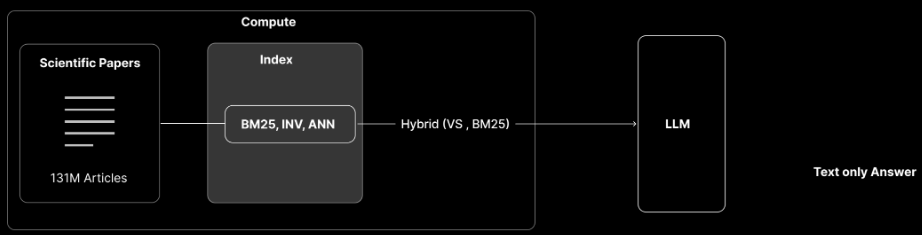

In the stage, the system enhances its search capabilities by combining BM25 with Approximate Nearest Neighbors (ANN) for a hybrid search. This approach blends lexical search with semantic search, improving relevance by considering both keywords and semantic meaning. The introduction of a Large Language Model (LLM) allows the system to generate text-based answers, delivering direct responses instead of simply listing relevant documents.

We open the `vector_search` dataset to perform a hybrid search. First, we define a query `"Let's grab a drink"` and generate its embedding using `embedding_function(query)[0]`. We then convert this embedding into a comma-separated string `embedding_string`, preparing it for use in combined text and vector-based searches.

In [86]:
vector_search = deeplake.open(f"al://{org_id}/{dataset_name_vs}")

### Search for the correct restaurant using a specific sentence

In [18]:
query = "I feel like a drink"
embed_query = embedding_function(query)[0]
embedding_string = ",".join(str(c) for c in embed_query)

We create two queries:
 
1. **Vector Search**  (`tql_vs`): Calculates cosine similarity with `embedding_string` and returns the top 5 matches by score.
 
2. **BM25 Search**  (`tql_bm25`): Ranks `restaurant_review` by BM25 similarity to `query`, also limited to the top 5.

We then execute both queries, storing vector results in `vs_results` and BM25 results in `bm25_results`. This allows us to compare results from both search methods.

In [19]:
tql_vs = f"""
    SELECT *
    FROM (
        SELECT *, cosine_similarity(embedding, ARRAY[{embedding_string}]) AS score 
        FROM (
            SELECT *, ROW_NUMBER() AS row_id
        )
    
    )
    ORDER BY score DESC 
    LIMIT 5
"""

tql_bm25 = f"""
    SELECT *, BM25_SIMILARITY(restaurant_review, '{query}') AS score 
    FROM (
        SELECT *, ROW_NUMBER() AS row_id
    ) 
    ORDER BY BM25_SIMILARITY(restaurant_review, '{query}') DESC 
    LIMIT 5
"""

vs_results = vector_search.query(tql_vs)
bm25_results = vector_search.query(tql_bm25)

In [166]:
vs_results

Dataset(columns=(embedding,restaurant_name,restaurant_review,owner_answer,row_id,score), length=5)

In [167]:
bm25_results

Dataset(columns=(embedding,restaurant_name,restaurant_review,owner_answer,row_id,score), length=5)

### Show the scores

In [168]:
for el_vs in vs_results:
    print(f"vector search score: {el_vs['score']}")

for el_bm25 in bm25_results:
    print(f"bm25 score: {el_bm25['score']}")

vector search score: 0.5322654247283936
vector search score: 0.46281781792640686
vector search score: 0.4580579102039337
vector search score: 0.45585304498672485
vector search score: 0.4528498649597168
bm25 score: 13.076177597045898
bm25 score: 11.206666946411133
bm25 score: 11.023599624633789
bm25 score: 10.277934074401855
bm25 score: 10.238584518432617


First, we import the required libraries and define a Document class, where each document has an id, a data dictionary, and an optional score for ranking.

1. **Setup and Classes** : 
  - We import necessary libraries and define a `Document` class using `pydantic.BaseModel`. Each `Document` has an `id`, a `data` dictionary, and an optional `score` for ranking.
 
2. **Softmax Function** : 
  - The `softmax` function normalizes a list of scores (`retrieved_score`) using the softmax formula. Scores are exponentiated, limited by `max_weight`, and then normalized to sum up to 1. This returns `new_weights`, a list of normalized scores.

Install the required libraries

In [ ]:
!pip install numpy pydantic

In [118]:
import math
import numpy as np
from typing import Any, Dict, List, Optional
from pydantic import BaseModel

class Document(BaseModel):
    id: str
    data: Dict[str, Any]
    score: Optional[float] = None

def softmax(retrieved_score: list[float], max_weight: int = 700) -> Dict[str, Document]:
    # Compute the exponentials
    exp_scores = [math.exp(min(score, max_weight)) for score in retrieved_score]
    
    # Compute the sum of the exponentials
    sum_exp_scores = sum(exp_scores)

    # Update the scores of the documents using softmax
    new_weights = []
    for score in exp_scores:
        new_weights.append(score / sum_exp_scores)

    return new_weights

### Normalize the score

3. **Apply Softmax to Scores** : 
  - We extract `score` values from `vs_results` and `bm25_results` and apply `softmax` to them, storing the results in `vss` and `bm25s`. This step scales both sets of scores for easy comparison.
 
4. **Create Document Dictionaries** : 
  - We create dictionaries `docs_vs` and `docs_bm25` to store documents from `vs_results` and `bm25_results`, respectively. For each result, we add the `restaurant_name` and `restaurant_review` along with the normalized score. Each document is identified by `row_id`.

This code standardizes scores and organizes results, allowing comparison across both vector and BM25 search methods.

In [169]:
vs_score = vs_results["score"]
bm_score = bm25_results["score"]

vss = softmax(vs_score)
bm25s = softmax(bm_score)
print(vss)
print(bm25s)

[0.21224761685297047, 0.19800771415362647, 0.1970674552539808, 0.19663342673946818, 0.19604378699995426]
[0.7132230191866898, 0.10997834807700335, 0.09158030054295993, 0.04344738382536802, 0.04177094836797888]


In [170]:
vs_results

Dataset(columns=(embedding,restaurant_name,restaurant_review,owner_answer,row_id,score), length=5)

In [171]:
docs_vs = {}
docs_bm25 = {}
for el, score in zip(vs_results, vss):
    docs_vs[str(el["row_id"])] = Document(id=str(el["row_id"]), data={"restaurant_name": el["restaurant_name"], "restaurant_review": el["restaurant_review"]}, score=score)
    
for el, score in zip(bm25_results, bm25s):
    docs_bm25[str(el["row_id"])] = Document(id=str(el["row_id"]), data={"restaurant_name": el["restaurant_name"], "restaurant_review": el["restaurant_review"]}, score=score)


We define weights for our hybrid search: `VECTOR_WEIGHT` and `LEXICAL_WEIGHT` are both set to `0.5`, giving equal importance to vector-based and BM25 scores. 
1. **Initialize Results Dictionary** : 
  - We create an empty dictionary, `results`, to store documents with their combined scores from both search methods.
 
2. **Combine Scores** : 
  - We iterate over the unique document IDs from `docs_vs` and `docs_bm25`.
 
  - For each document: 
    - We add it to `results`, defaulting to the version available (vector or BM25).
 
    - We calculate a weighted score: `vs_score` from vector results (if present in `docs_vs`) and `bm_score` from BM25 results (if present in `docs_bm25`).
 
    - The final `results[k].score` is set by adding `vs_score` and `bm_score`.
    
This produces a fused score for each document in `results`, ready to rank in the hybrid search.


In [172]:
docs_vs

{'17502': Document(id='17502', data={'restaurant_name': "St. Stephen's Green", 'restaurant_review': 'Nice place for a drink'}, score=0.21224761685297047),
 '17444': Document(id='17444', data={'restaurant_name': "St. Stephen's Green", 'restaurant_review': 'Good drinks, good food'}, score=0.19800771415362647),
 '4022': Document(id='4022', data={'restaurant_name': 'Eureka! Mountain View', 'restaurant_review': 'Good drinks and burgers'}, score=0.1970674552539808),
 '17426': Document(id='17426', data={'restaurant_name': "St. Stephen's Green", 'restaurant_review': 'Good drinks an easy going bartenders'}, score=0.19663342673946818),
 '5136': Document(id='5136', data={'restaurant_name': 'Scratch', 'restaurant_review': 'Just had drinks. They were good!'}, score=0.19604378699995426)}

In [173]:
docs_bm25

{'3518': Document(id='3518', data={'restaurant_name': 'Olympus Caffe & Bakery', 'restaurant_review': 'I like the garden to sit down with friends and have a drink.'}, score=0.7132230191866898),
 '2637': Document(id='2637', data={'restaurant_name': 'Mifen101 花溪米粉王', 'restaurant_review': 'Feel like I’m back in China.'}, score=0.10997834807700335),
 '11383': Document(id='11383', data={'restaurant_name': 'Ludwigs Biergarten Mountain View', 'restaurant_review': 'Beer is fresh tables are big feel like a proper beer garden'}, score=0.09158030054295993),
 '2496': Document(id='2496', data={'restaurant_name': 'Seasons Noodles & Dumplings Garden', 'restaurant_review': 'Comfort food, excellent service! Feel like back to home.'}, score=0.04344738382536802),
 '10788': Document(id='10788', data={'restaurant_name': 'Casa Lupe', 'restaurant_review': 'Run by a family that makes you feel like part of the family. Awesome food. I love their wet Chili Verde burritos'}, score=0.04177094836797888)}

### Fusion method

In [174]:

def fusion(docs_vs: Dict[str, Document], docs_bm25: Dict[str, Document]) -> Dict[str, Document]:
    VECTOR_WEIGHT = 0.5
    LEXICAL_WEIGHT = 0.5

    results: Dict[str, Dict[str, Document]] = {}
    

    for k in set(docs_vs) | set(docs_bm25):
        results[k] = docs_vs.get(k, None) or docs_bm25.get(k, None)
        vs_score = VECTOR_WEIGHT * docs_vs[k].score if k in docs_vs else 0
        bm_score = LEXICAL_WEIGHT * docs_bm25[k].score if k in docs_bm25 else 0
        results[k].score = vs_score + bm_score

    return results


In [181]:
results = fusion(docs_vs, docs_bm25)
results

{'2637': Document(id='2637', data={'restaurant_name': 'Mifen101 花溪米粉王', 'restaurant_review': 'Feel like I’m back in China.'}, score=0.013747293509625419),
 '5136': Document(id='5136', data={'restaurant_name': 'Scratch', 'restaurant_review': 'Just had drinks. They were good!'}, score=0.024505473374994282),
 '17426': Document(id='17426', data={'restaurant_name': "St. Stephen's Green", 'restaurant_review': 'Good drinks an easy going bartenders'}, score=0.024579178342433523),
 '17444': Document(id='17444', data={'restaurant_name': "St. Stephen's Green", 'restaurant_review': 'Good drinks, good food'}, score=0.02475096426920331),
 '2496': Document(id='2496', data={'restaurant_name': 'Seasons Noodles & Dumplings Garden', 'restaurant_review': 'Comfort food, excellent service! Feel like back to home.'}, score=0.005430922978171003),
 '4022': Document(id='4022', data={'restaurant_name': 'Eureka! Mountain View', 'restaurant_review': 'Good drinks and burgers'}, score=0.0246334319067476),
 '3518': D

We sort the results dictionary by each document's combined score in descending order, ensuring that the highest-ranking documents appear first.

In [179]:
sorted_documents = dict(sorted(results.items(), key=lambda item: item[1].score, reverse=True))
sorted_documents

{'3518': Document(id='3518', data={'restaurant_name': 'Olympus Caffe & Bakery', 'restaurant_review': 'I like the garden to sit down with friends and have a drink.'}, score=0.3566115095933449),
 '17502': Document(id='17502', data={'restaurant_name': "St. Stephen's Green", 'restaurant_review': 'Nice place for a drink'}, score=0.10612380842648524),
 '17444': Document(id='17444', data={'restaurant_name': "St. Stephen's Green", 'restaurant_review': 'Good drinks, good food'}, score=0.09900385707681324),
 '4022': Document(id='4022', data={'restaurant_name': 'Eureka! Mountain View', 'restaurant_review': 'Good drinks and burgers'}, score=0.0985337276269904),
 '17426': Document(id='17426', data={'restaurant_name': "St. Stephen's Green", 'restaurant_review': 'Good drinks an easy going bartenders'}, score=0.09831671336973409),
 '5136': Document(id='5136', data={'restaurant_name': 'Scratch', 'restaurant_review': 'Just had drinks. They were good!'}, score=0.09802189349997713),
 '2637': Document(id='

### Show the results

We will output a list of restaurants in order of relevance, showing each name and review based on the hybrid search results.

In [182]:
for v in sorted_documents.values():
    print(f"Restaurant name: {v.data['restaurant_name']} \nReview: {v.data['restaurant_review']}")

Restaurant name: Olympus Caffe & Bakery 
Review: I like the garden to sit down with friends and have a drink.
Restaurant name: St. Stephen's Green 
Review: Nice place for a drink
Restaurant name: St. Stephen's Green 
Review: Good drinks, good food
Restaurant name: Eureka! Mountain View 
Review: Good drinks and burgers
Restaurant name: St. Stephen's Green 
Review: Good drinks an easy going bartenders
Restaurant name: Scratch 
Review: Just had drinks. They were good!
Restaurant name: Mifen101 花溪米粉王 
Review: Feel like I’m back in China.
Restaurant name: Ludwigs Biergarten Mountain View 
Review: Beer is fresh tables are big feel like a proper beer garden
Restaurant name: Seasons Noodles & Dumplings Garden 
Review: Comfort food, excellent service! Feel like back to home.
Restaurant name: Casa Lupe 
Review: Run by a family that makes you feel like part of the family. Awesome food. I love their wet Chili Verde burritos



This code completes the RAG (Retrieval-Augmented Generation) approach by generating an LLM-based answer to a user’s question, using results retrieved in the previous step. Here’s how it works:
 
1. **Setup and Initialization** : 
  - We import `json` for handling JSON responses and initialize the `OpenAI` client to interact with the language model.
 
2. **Define `generate_question` Function** : 
  - This function accepts: 
    - `question`: The user’s question.
 
    - `information`: A list relevant chunks retrieved previously, providing context.
 
3. **System and User Prompts** : 
  - The `system_prompt` instructs the model to act as a restaurant assistant, using the provided chunks to answer clearly and without repetition.
 
  - The model is directed to format its response in JSON.
 
  - The `user_prompt` combines the user’s question and the information chunks.
 
4. **Generate and Parse the Response** : 
  - Using `client.chat.completions.create()`, the system and user prompts are sent to the LLM (specified as `gpt-4o-mini`).
 
  - The response is parsed as JSON, extracting the `answer` field. If parsing fails, `False` is returned.

In [185]:
import json
from openai import OpenAI

client = OpenAI()

def generate_question(question:str, information:list):

    system_prompt = f"""You are a helpful assistant specialized in providing answers to questions about restaurants. Below is a question from a user, along with the top four relevant information chunks about restaurants from a Deep Lake database. Using these chunks, construct a clear and informative answer that addresses the question, incorporating key details without repeating information.
    The output must be in JSON format with the following structure:
    {{
        "answer": "The answer to the question."
    }}

    """

    user_prompt = f"Here is a question from a user: {question}\n\nHere are the top relevant information about restaurants {information}"
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ],
        response_format={"type": "json_object"},
    )

    try:
        response = response.choices[0].message.content
        response = json.loads(response)
        questions = response["answer"]
        return questions
    except:
        return False

This function takes a restaurant-related question and retrieves the best response based on the given context. It completes the RAG process by combining relevant information and LLM-generated content into a concise answer.

In [186]:
information = [f'Review: {el["restaurant_review"]}, Restaurant name: {el["restaurant_name"]}' for el in view_vs]
result = generate_question(query, information)
result

"If you're feeling like a drink, consider visiting Taqueria La Espuela, which is known for its refreshing horchata. Alternatively, you might enjoy Chaat Bhavan Mountain View, a great place with good food and a lively atmosphere."

### Let's run a search on a multiple dataset

In this approach, we perform the hybrid search across two separate datasets: `vector_search` for vector-based search results and `ds_bm25` for BM25-based text search results. This allows us to independently query and retrieve scores from each dataset, then combine them using the same fusion method as before.

In [ ]:
ds_bm25 = deeplake.open(f"al://{org_id}/{dataset_name_bm25}")
vs_results = vector_search.query(tql_vs)
bm25_results = ds_bm25.query(tql_bm25)

In [190]:
vs_score = vs_results["score"]
bm_score = bm25_results["score"]

vss = softmax(vs_score)
bm25s = softmax(bm_score)

In [191]:
docs_vs = {}
docs_bm25 = {}
for el, score in zip(vs_results, vss):
    docs_vs[str(el["row_id"])] = Document(id=str(el["row_id"]), data={"restaurant_name": el["restaurant_name"], "restaurant_review": el["restaurant_review"]}, score=score)

for el, score in zip(bm25_results, bm25s):
    docs_bm25[str(el["row_id"])] = Document(id=str(el["row_id"]), data={"restaurant_name": el["restaurant_name"], "restaurant_review": el["restaurant_review"]}, score=score)

In [192]:
results = fusion(docs_vs, docs_bm25)

In [193]:
for v in sorted_documents.values():
    print(f"Restaurant name: {v.data['restaurant_name']} \nReview: {v.data['restaurant_review']}")

Restaurant name: Olympus Caffe & Bakery 
Review: I like the garden to sit down with friends and have a drink.
Restaurant name: St. Stephen's Green 
Review: Nice place for a drink
Restaurant name: St. Stephen's Green 
Review: Good drinks, good food
Restaurant name: Eureka! Mountain View 
Review: Good drinks and burgers
Restaurant name: St. Stephen's Green 
Review: Good drinks an easy going bartenders
Restaurant name: Scratch 
Review: Just had drinks. They were good!
Restaurant name: Mifen101 花溪米粉王 
Review: Feel like I’m back in China.
Restaurant name: Ludwigs Biergarten Mountain View 
Review: Beer is fresh tables are big feel like a proper beer garden
Restaurant name: Seasons Noodles & Dumplings Garden 
Review: Comfort food, excellent service! Feel like back to home.
Restaurant name: Casa Lupe 
Review: Run by a family that makes you feel like part of the family. Awesome food. I love their wet Chili Verde burritos


### Comparison of Sync vs Async Query Performance

This code performs an asynchronous query on a Deep Lake dataset. It begins by opening the dataset asynchronously using `await deeplake.open_async()`, specifying `org_id` and `dataset_name_vs`.

In [194]:
ds_async = await deeplake.open_async(f"al://{org_id}/{dataset_name_vs}")
ds_async_results = ds_async.query_async(tql_vs).result()

This following code compares the execution times of synchronous and asynchronous queries on a Deep Lake dataset:

- First, it records the start time `start_sync` for the synchronous query, executes the query with `vector_search.query(tql_vs)`, and then records the end time `end_sync`. It calculates and prints the total time taken for the synchronous query by subtracting `start_sync` from `end_sync`.
- Next, it measures the asynchronous query execution by recording `start_async`, running `vector_search.query_async(tql_vs).result()` to execute and retrieve the query result asynchronously, and then recording `end_async`. The asynchronous query time is calculated as the difference between `end_async` and `start_async`, and is printed.


The code executes two queries both synchronously and asynchronously, measuring the execution time for each method. In the synchronous part, the queries are executed one after the other, and the execution time is recorded. In the asynchronous part, the queries are run concurrently using `asyncio.gather()` to parallelize the asynchronous calls, and the execution time is also measured. The "speed factor" is then calculated by comparing the execution times, showing how much faster the asynchronous execution is compared to the synchronous one. Using `asyncio.gather()` allows the asynchronous queries to run in parallel, reducing the overall execution time.

Finally, the code calculates the **speed factor**  by dividing the synchronous query time by the asynchronous query time, indicating how much faster the asynchronous query is. The speed factor is printed to compare the efficiency of asynchronous vs. synchronous execution.


In [45]:
import time
import asyncio
import nest_asyncio

nest_asyncio.apply()

async def run_async_queries():
    # Use asyncio.gather to run queries concurrently
    ds_async_results, ds_bm25_async_results = await asyncio.gather(
        vector_search.query_async(tql_vs),
        ds_bm25.query_async(tql_bm25)
    )
    return ds_async_results, ds_bm25_async_results

# Measure synchronous execution time
start_sync = time.time()
ds_sync_results = vector_search.query(tql_vs)
ds_bm25_sync_results = ds_bm25.query(tql_bm25)
end_sync = time.time()
print(f"Sync query time: {end_sync - start_sync}")

# Measure asynchronous execution time
start_async = time.time()
# Run the async queries concurrently using asyncio.gather
ds_async_results, ds_bm25_async_results = asyncio.run(run_async_queries())
end_async = time.time()
print(f"Async query time: {end_async - start_async}")

sync_time = end_sync - start_sync
async_time = end_async - start_async

# Calculate speed factor
speed_factor = sync_time / async_time

# Print the result
print(f"The async query is {speed_factor:.2f} times faster than the sync query.")


Sync query time: 0.09148645401000977
Async query time: 0.0657045841217041
The async query is 1.39 times faster than the sync query.


We can execute asynchronous queries even after loading the dataset synchronously. In the following example, we perform a BM25 query asynchronously on a dataset `ds_bm25` that was loaded synchronously. 

In [210]:
result_async_with_bm25 = ds_bm25.query_async(tql_bm25).result()
result_async_with_bm25

Dataset(columns=(restaurant_name,restaurant_review,owner_answer,row_id,score), length=5)

## 5) Integrating Image Embeddings for Multi-Modal Search

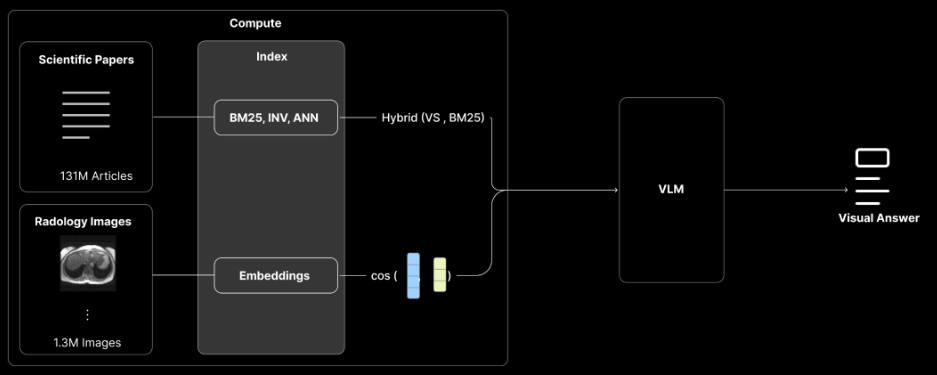

In the third stage, the system gains multi-modal retrieval capabilities, handling both papers and images. This setup allows for the retrieval of images alongside text, making it suitable for fields that require visual data, such as medicine and science. The use of cosine similarity on image embeddings enables it to rank images based on similarity to the query, while the Vision Language Model (VLM) allows the system to provide visual answers as well as text.

Install required libraries

In [ ]:
!pip install -U torchvision
!pip install git+https://github.com/openai/CLIP.git


To set up for image embedding generation, we start by importing necessary libraries.
 
1. **Set Device** : 
  - We define `device` to use GPU if available, otherwise defaulting to CPU, ensuring compatibility across hardware.
 
2. **Load CLIP Model** : 
  - We load the CLIP model (`ViT-B/32`) with its associated preprocessing steps using `clip.load()`. This model is optimized for multi-modal tasks and is set to run on the specified `device`.

This setup allows us to efficiently process images for embedding, supporting multi-modal applications like image-text similarity.


The following image illustrates the `CLIP` (Contrastive Language-Image Pretraining) model's structure, which aligns text and images in a shared embedding space, enabling cross-modal understanding.


![](https://github.com/openai/CLIP/raw/main/CLIP.png)

In [18]:
import torch
import clip

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

### Create the embedding function for images

To prepare images for embedding generation, we define a transformation pipeline and a function to process images in batches.

1. **Define Transformations (`tform`)** : 
  - The transformation pipeline includes: 
    - **Resize** : Scales images to 224x224 pixels.
 
    - **ToTensor** : Converts images to tensor format.
 
    - **Lambda** : Ensures grayscale images are replicated across three channels to match the RGB format.
 
    - **Normalize** : Standardizes pixel values based on common RGB means and standard deviations.
 
2. **Define `embedding_function_images`** :
  - This function generates embeddings for a list of image.
 
  - If `images` is a single filename, it’s converted to a list.
 
  - **Batch Processing** : Images are processed in batches (default size 4), with transformations applied to each image. The batch is then loaded to the device.
 
  - **Embedding Creation** : The model encodes each batch into embeddings, stored in the `embeddings` list, which is returned as a single list.

This function supports efficient, batched embedding generation, useful for multi-modal tasks like image-based search.

In [19]:
from torchvision import transforms

tform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.cat([x, x, x], dim=0) if x.shape[0] == 1 else x),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

def embedding_function_images(images, model = model, transform = tform, batch_size = 4):
    """Creates a list of embeddings based on a list of image. Images are processed in batches."""

    if isinstance(images, str):
        images = [images]

    # Proceess the embeddings in batches, but return everything as a single list
    embeddings = []
    for i in range(0, len(images), batch_size):
        batch = torch.stack([transform(item) for item in images[i:i+batch_size]])
        batch = batch.to(device)
        with torch.no_grad():
            embeddings+= model.encode_image(batch).cpu().numpy().tolist()

    return embeddings

### Create a new dataset to save the images

We set up a dataset for restaurant images and embeddings. The dataset includes an `embedding` column for 512-dimensional image embeddings, a `restaurant_name` column for names, and an `image` column for storing images in UInt8 format. After defining the structure, `vector_search_images.commit()` saves it, making the dataset ready for storing data for multi-modal search tasks with images and metadata.

In [1]:
import deeplake
scraped_data = deeplake.open_read_only("al://activeloop/restaurant_dataset_complete")

This code extracts restaurant details from `scraped_data` into separate lists: 
1. **Initialize Lists** : `restaurant_name` and `images` are initialized to store respective data for each restaurant.
 
2. **Populate Lists** : For each entry (`el`) in `scraped_data`, the code appends: 
  - `el['restaurant_name']` to `restaurant_name`,
 
  - `el['images']['urls']` to `images`.

After running, each list holds a specific field from all restaurants, ready for further processing.


In [2]:
restaurant_name = []
images = []
for el in scraped_data:
    restaurant_name.append(el['restaurant_name'])
    images.append(el['images']['urls'])

In [ ]:
image_dataset_name = "restaurant_dataset_with_images"
vector_search_images = deeplake.create(f"al://{org_id}/{image_dataset_name}")

vector_search_images.add_column(name="embedding", dtype=types.Embedding(512))
vector_search_images.add_column(name="restaurant_name", dtype=types.Text())
vector_search_images.add_column(name="image", dtype=types.Image(dtype=types.UInt8()))

vector_search_images.commit()

### Convert the URLs into images

We retrieve images for each restaurant from URLs in scraped_data and store them in restaurants_images. For each restaurant, we extract image URLs, request each URL, and filter for successful responses (status code 200). These responses are then converted to PIL images and added to restaurants_images as lists of images, with each sublist containing the images for one restaurant.

In [ ]:
!pip install requests

In [ ]:
import requests
from PIL import Image
from io import BytesIO

restaurants_images = []
for urls in images:
    pil_images = []
    for url in urls:
        response = requests.get(url)
        if response.status_code == 200:
            image = Image.open(BytesIO(response.content))
            if image.mode == "RGB":
                pil_images.append(image)
    if len(pil_images) == 0:
        pil_images.append(Image.new("RGB", (224, 224), (255, 255, 255)))
    restaurants_images.append(pil_images)

We populate `vector_search_images` with restaurant image data and embeddings. For each restaurant in `scraped_data`, we retrieve its name and images, create embeddings for the images, and convert them to `UInt8` arrays. Then, we append the restaurant names, images, and embeddings to the dataset and save with `vector_search_images.commit()`. 

In [ ]:
import numpy as np

for sd, rest_images in zip(scraped_data, restaurants_images):
    restaurant_name = [sd["restaurant_name"]] * len(rest_images)
    embeddings = embedding_function_images(rest_images, model=model, transform=tform, batch_size=4)
    vector_search_images.append({"restaurant_name": restaurant_name, "image": [np.array(fn).astype(np.uint8) for fn in rest_images], "embedding": embeddings})

vector_search_images.commit()

### Search similar images

If you want direct access to the images and the embeddings, you can copy the Activeloop dataset.

In [14]:
deeplake.copy("al://activeloop/restaurant_dataset_images_v4", f"al://{org_id}/{image_dataset_name}")
vector_search_images = deeplake.open(f"al://{org_id}/{image_dataset_name}")

Alternatively, you can load the dataset you just created.

In [ ]:
vector_search_images = deeplake.open(f"al://{org_id}/{image_dataset_name}")
vector_search_images

In [15]:
query = "https://www.moltofood.it/wp-content/uploads/2024/09/Hamburger.jpg"

image_query = requests.get(query)
image_query_pil = Image.open(BytesIO(image_query.content))

### Performing a similar image search based on a specific image

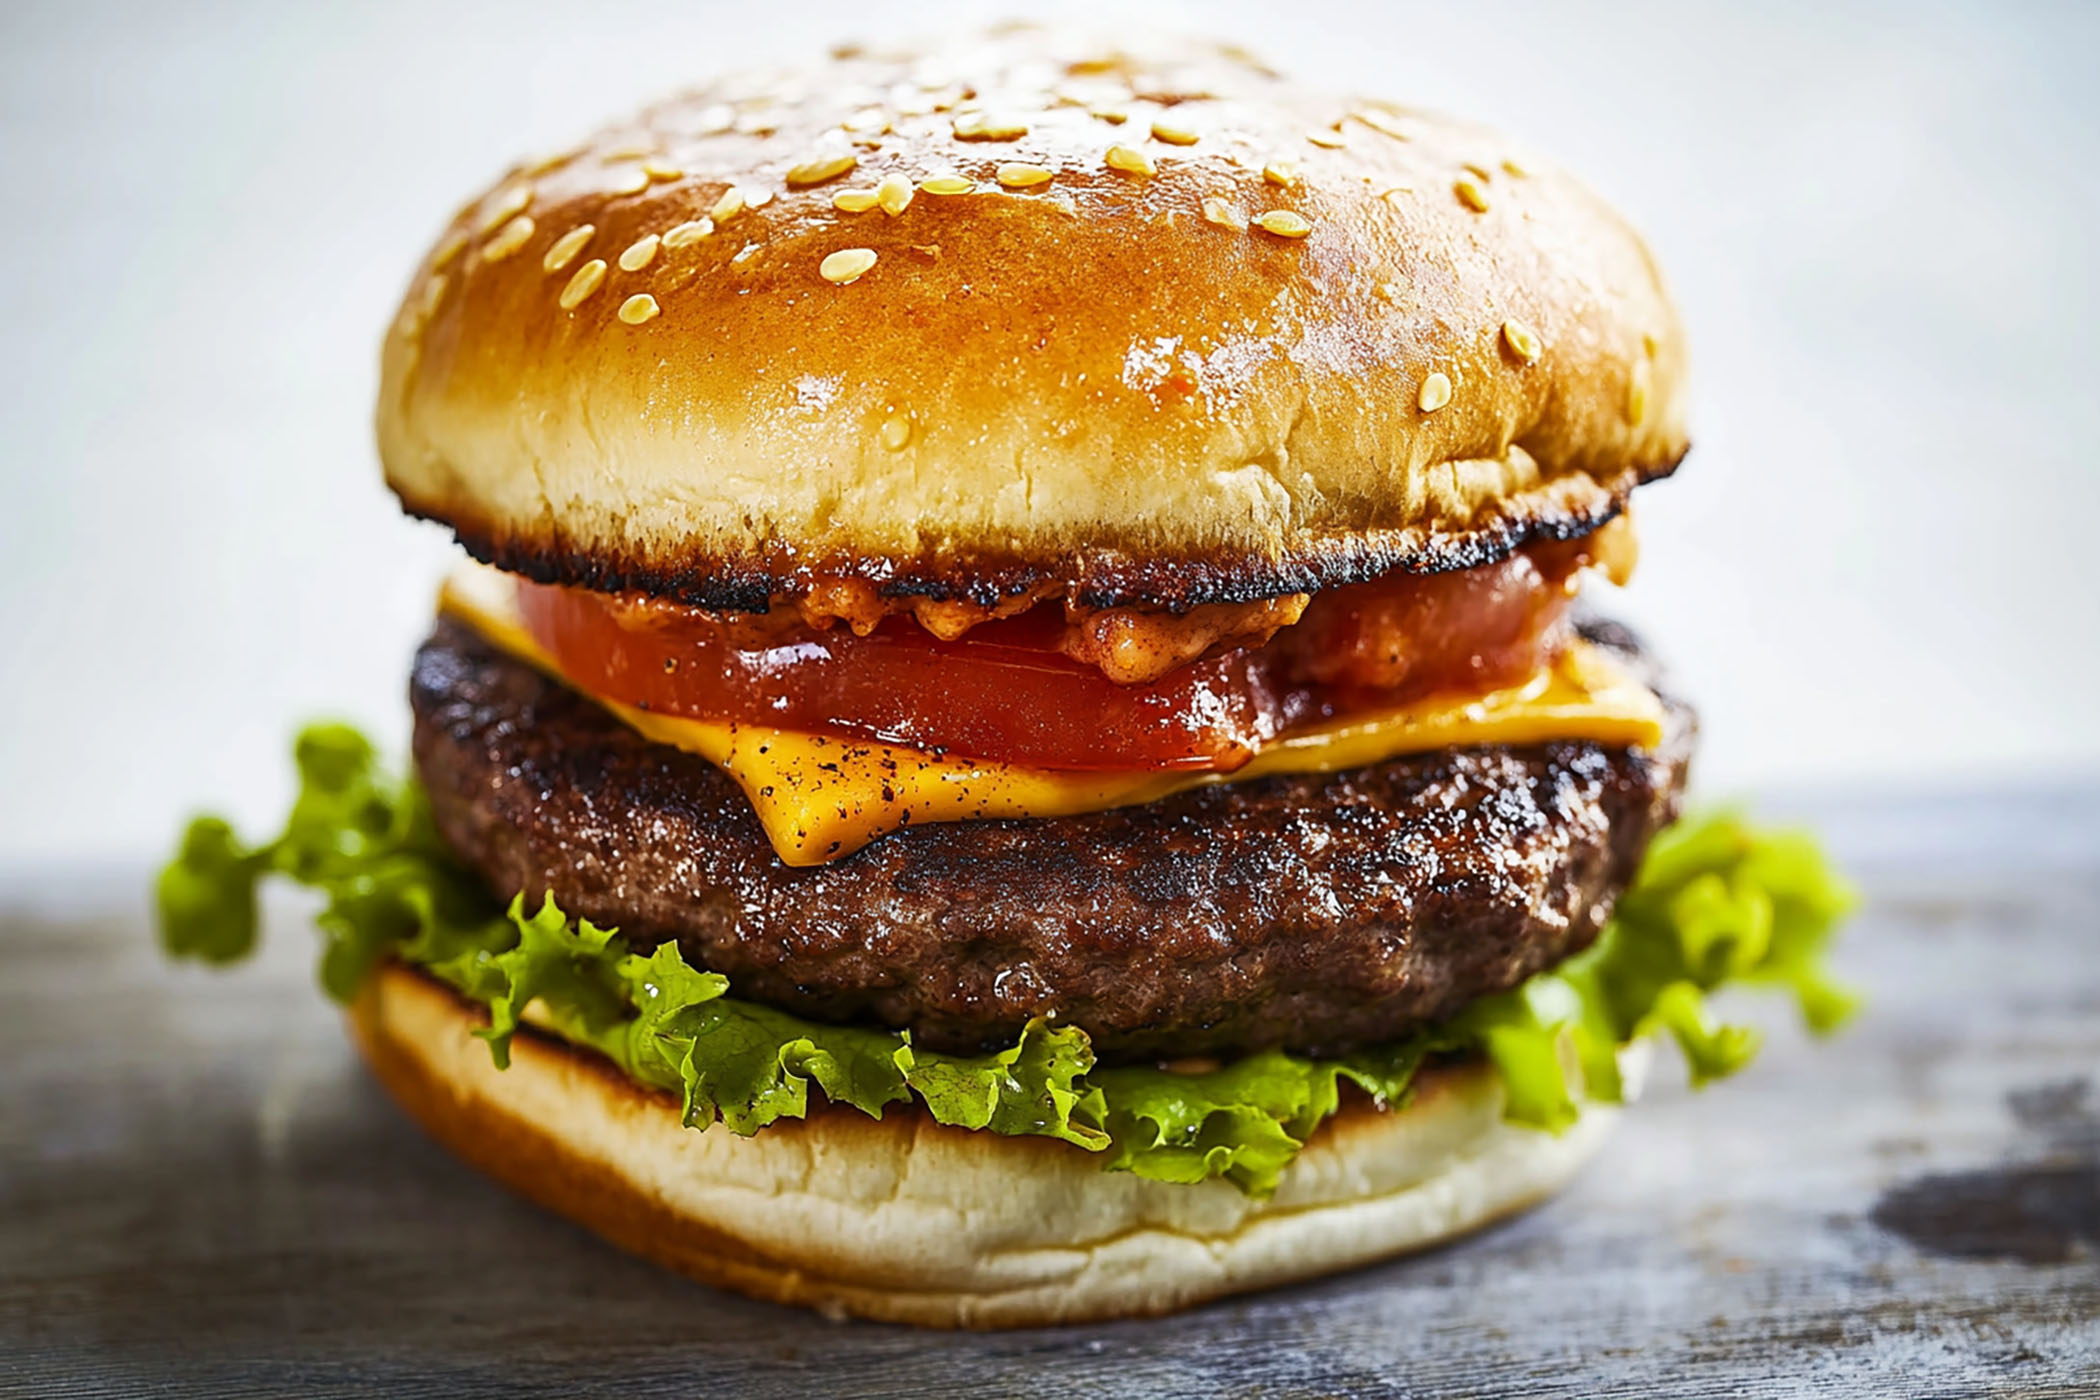

In [16]:
image_query_pil

We generate an embedding for the query image, `image_query_pil`, by calling `embedding_function_images([image_query_pil])[0]`. This embedding is then converted into a comma-separated string, `query_embedding_string`, for compatibility in the query.The query, `tql`, retrieves entries from the dataset by calculating cosine similarity between `embedding` and `query_embedding_string`. It ranks results by similarity score in descending order, limiting the output to the top 6 most similar images.

In [25]:
query_embedding = embedding_function_images([image_query_pil])[0]
query_embedding_string = ",".join([str(item) for item in query_embedding])

tql = f"""
    SELECT * 
    FROM (
        SELECT *, cosine_similarity(embedding, ARRAY[{query_embedding_string}]) AS score 
        FROM (
            SELECT *, ROW_NUMBER() AS row_id
        )
    ) 
    ORDER BY score DESC 
    LIMIT 6
"""

In [26]:
similar_images_result = vector_search_images.query(tql)
similar_images_result

Dataset(columns=(embedding,restaurant_name,image,row_id,score), length=6)

### Show similar images and the their respective restaurants

In [ ]:
!pip install matplotlib

The `show_images` function displays a grid of similar images, along with restaurant names and similarity scores. It defines a grid with 3 columns and calculates the required number of rows based on the number of images. A figure with subplots is created, where each image is displayed in a cell with its restaurant name and similarity score shown as the title, and axes turned off for a cleaner look. Any extra cells, if present, are hidden to avoid empty spaces. Finally, `plt.tight_layout()` arranges the grid, and `plt.show()` displays the images in a well-organized layout, highlighting the most similar images along with their metadata.

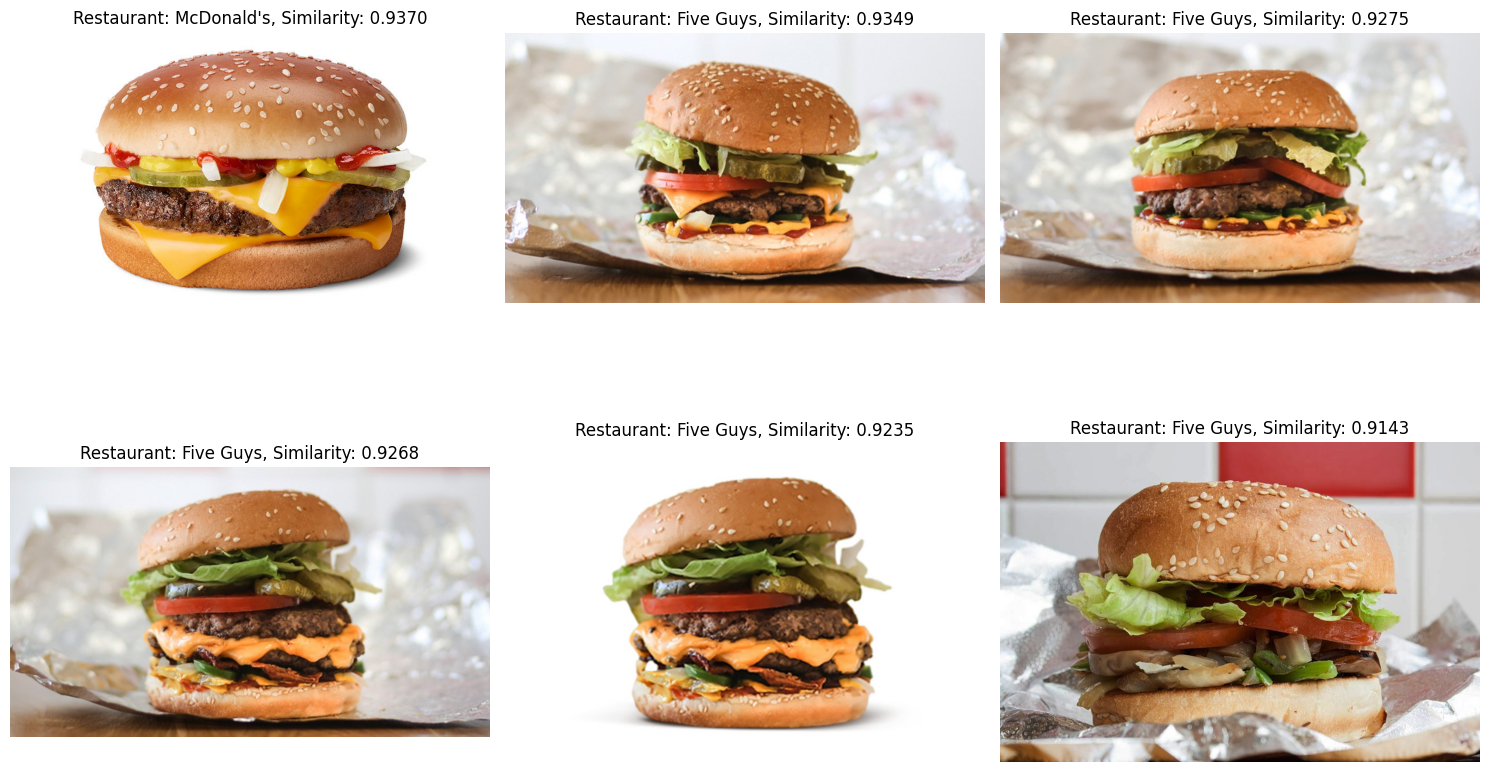

In [27]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def show_images(similar_images: list[dict]):
    # Define the number of rows and columns for the grid
    num_columns = 3
    num_rows = (len(similar_images) + num_columns - 1) // num_columns  # Calculate the required number of rows

    # Create the grid
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))
    axes = axes.flatten()  # Flatten for easier access to cells

    for idx, el in enumerate(similar_images):
        img = Image.fromarray(el["image"])
        axes[idx].imshow(img)
        axes[idx].set_title(f"Restaurant: {el['restaurant_name']}, Similarity: {el['score']:.4f}")
        axes[idx].axis('off')  # Turn off axes for a cleaner look

    # Remove empty axes if the number of images doesn't fill the grid
    for ax in axes[len(similar_images):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

show_images(similar_images_result)

## 6) ColBERT: Efficient and Effective Passage Search via Contextualized Late Interaction over BERT

ColBERT is a model designed to efficiently retrieve and rank passages by leveraging the power of deep language models like BERT, but with a unique approach called **late interaction**. In traditional information retrieval, a model often computes detailed interactions between the query and every document at an early stage, which is computationally expensive, especially with large datasets. **Late interaction** , however, postpones this detailed interaction until a later stage.

At the final stage of retrieval, **late interaction**  occurs: each query token embedding interacts with the most relevant document token embeddings, using a simplified comparison (e.g., cosine similarity or max similarity). 

This targeted, late-stage interaction allows the model to capture fine-grained relationships between query and document content without requiring full-scale interactions upfront.

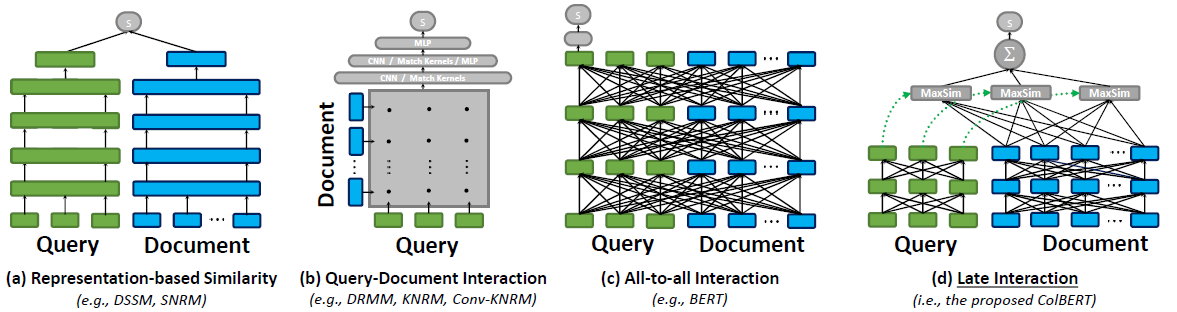


To use ColBERT, we can leverage the `colbert-ai` library. We’ll start by installing it:

In [ ]:
!pip install -U colbert-ai torch


In this snippet, we are loading a pretrained ColBERT model checkpoint for use in information retrieval tasks. Here’s what each part does:
 
1. **Importing Modules** : 
  - `Checkpoint` is a utility from ColBERT that allows loading and managing pretrained model checkpoints.
 
  - `ColBERTConfig` provides configuration options for the ColBERT model, such as directory paths and other settings.
 
2. **Initializing the Checkpoint** : 
  - `"colbert-ir/colbertv2.0"` specifies the name of the pretrained checkpoint to load. This could be a path to a local model file or a remote model identifier, depending on your setup.
 
  - `ColBERTConfig(root="experiments")` sets the root directory where model-related experiments will be saved or accessed. This is useful for organizing logs, results, and intermediate files.
 
3. **Purpose** : 
  - The `ckpt` object now contains the pretrained ColBERT model and its configuration, ready to be used for tasks like ranking or embedding documents in information retrieval pipelines.

This step sets up the foundation for using ColBERT's capabilities in semantic search and ranking tasks efficiently.


In [ ]:
from colbert.modeling.checkpoint import Checkpoint
from colbert.infra import ColBERTConfig

ckpt = Checkpoint(
    "colbert-ir/colbertv2.0", colbert_config=ColBERTConfig(root="experiments")
)

In this example, we copy, structure, and process a **medical dataset**  to generate embeddings for text documents using a pretrained ColBERT model. 

1. **Dataset Copy and Setup** : 
  - The `deeplake.copy()` function duplicates the `medical_dataset` from the Activeloop repository into your organization’s workspace.
 
  - `deeplake.open()` then opens the dataset for modifications, allowing us to add or manipulate columns.
 
2. **Adding an Embedding Column** : 
  - A new column named `embedding` is added to the dataset with the data type `types.Array(types.Float32(), dimensions=2)`, preparing it to store 2D embeddings generated from the medical text.
 


In [ ]:
deeplake.copy(f"al://activeloop/medical_dataset", f"al://{org_id}/medical_dataset")

In [9]:
medical_dataset = deeplake.open(f"al://{org_id}/medical_dataset")
medical_dataset.summary()

Dataset(columns=(text,embedding), length=19719)
+---------+---------------------------------------+
| column  |                 type                  |
+---------+---------------------------------------+
|  text   |                 text                  |
+---------+---------------------------------------+
|embedding|array(dtype=float32, shape=[None,None])|
+---------+---------------------------------------+



In [9]:
medical_dataset.add_column(name="embedding", dtype=types.Array(types.Float32(),dimensions=2))
medical_dataset.commit()

3. **Text Extraction** : 
  - The text data from the medical dataset is extracted into a list (`medical_text`) by iterating over the dataset and pulling the `text` field for each entry.
 
4. **Batch Embedding Generation** : 
  - The text data is processed in batches of 1,000 entries using the ColBERT model (`ckpt.docFromText`), which generates embeddings for each batch.
 
  - The embeddings are appended to a list (`all_vectors`) for later use.
 
5. **Efficient Processing** :
  - Batching ensures efficient processing, especially when dealing with large datasets, as it prevents memory overload and speeds up embedding generation.


In [12]:
all_vectors = []
medical_text = [el["text"] for el in medical_dataset]

for i in range(0, len(medical_text), 1000):
    chunk = medical_text[i:i+1000]
    vectors_chunk = ckpt.docFromText(chunk)
    all_vectors.extend(vectors_chunk)

In [22]:
list_of_embeddings = [vector.tolist() for vector in all_vectors]
len(list_of_embeddings)

19719


We convert the embeddings into Python lists for compatibility with Deep Lake storage and checks the total number of embeddings. Each embedding from all_vectors is transformed using `.tolist()`, creating list_of_embeddings, and `len(list_of_embeddings)` confirms the total count matches the processed text entries.

In [49]:
medical_dataset["embedding"][0:len(list_of_embeddings)] = list_of_embeddings
medical_dataset.commit()

This code performs a semantic search using ColBERT embeddings, leveraging the MaxSim operator, executed directly in the cloud (as described in the `index-on-the-lake` section), for efficient similarity computations.

1. **Query Embedding** : The query is embedded with `ckpt.queryFromText` and converted into a format compatible with TQL queries.
 


In [ ]:
query_vectors = ckpt.queryFromText(["What were the key risk factors for the development of posthemorrhagic/postoperative epilepsy in the study?"])[0]
query_vectors = query_vectors.tolist()

2. **TQL Query Construction** : The `maxsim` function compares the query embedding to dataset embeddings, ranking results by similarity and limiting them to the top `n_res` matches.
 
3. **Query Execution** : `medical_dataset.query` retrieves the most relevant entries based on semantic similarity.


In [7]:
n_res = 10
q_substrs = [f"ARRAY[{','.join(str(x) for x in sq)}]" for sq in query_vectors]
q_str = f"ARRAY[{','.join(q_substrs)}]"

# Construct a formatted TQL query
tql_colbert = f"""
    SELECT *, maxsim({q_str}, embedding) AS score 
    ORDER BY maxsim({q_str}, embedding) DESC 
    LIMIT {n_res}
"""

# Execute the query and append the results
results = medical_dataset.query(tql_colbert)

Here are the results:

In [26]:
for res in results:
    print(f"Text: {res['text']}")

Text: In resistant dogs, myocardial infarction did not affect any measure of heart rate variability: 1) mean RR interval, 2) standard deviation of the mean RR interval, and 3) the coefficient of variance (standard deviation/RR interval). By contrast, after myocardial infarction, susceptible dogs showed significant decrease in all measures of heart rate variability. Before myocardial infarction, no differences were seen between susceptible and resistant dogs. However, 30 days after infarction, epidemiologic analysis of the coefficient of variance showed high sensitivity and specificity (88% and 80%, respectively), predicting susceptibility. Therefore, results of analysis of 30 min of beat to beat heart period at rest 30 days after myocardial infarction are highly predictive for increased risk of sudden death. \n5\tMultiple organ failure: inflammatory priming and activation sequences promote autologous tissue injury. Systemic inflammation promotes multiple organ failure through the induc

## 7) Discover Restaurants Using ColPali and the Late Interaction Mechanism

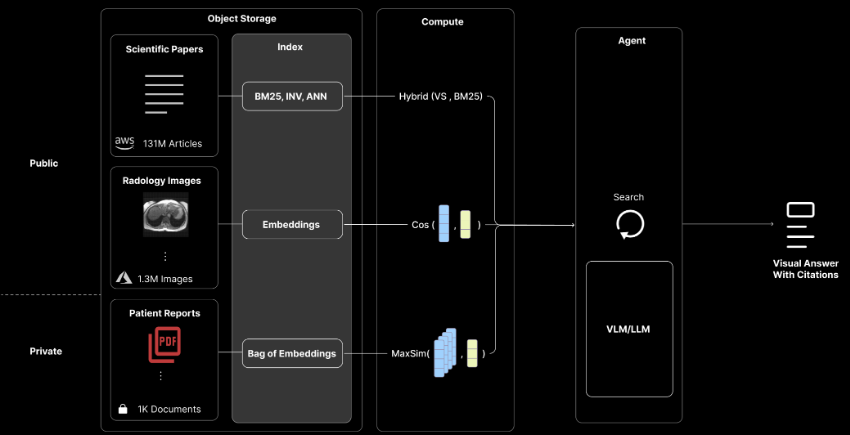

In this final stage, the system uses an **end-to-end neural search**  approach with a focus on the **MaxSim**  operator, as implemented in ColPali, to improve multi-modal retrieval. MaxSim allows the system to compare different types of data, like text and images, and find the most relevant matches. This helps retrieve results that are contextually accurate and meaningful, making it especially useful for complex applications, like scientific and medical research, where a deep understanding of the content is essential.

Recent advancements in Visual Language Models (VLMs), as highlighted in the ColPali paper, demonstrate that VLMs can achieve recall rates on document retrieval benchmarks comparable to those of traditional OCR pipelines. End-to-end learning approaches are positioned to surpass OCR-based methods significantly. However, representing documents as a `bag of embeddings` demands 30 times more storage than single embeddings. Deep Lake’s format, which inherently supports n-dimensional arrays, enables this storage-intensive approach, and the 4.0 query engine introduces MaxSim operations.

With Deep Lake 4.0’s 10x increase in storage efficiency, we can allocate some of these savings to store PDFs as 'bags of embeddings' processed at high speeds. While this approach requires 30 times more storage than single embeddings, it allows us to capture richer document representations, bypassing OCR-based, manual feature engineering pipelines. This trade-off facilitates seamless integration within VLM/LLM frameworks, leading to more accurate and genuinely multimodal responses.

Unlike CLIP, which primarily focuses on aligning visual and text representations, ColPali leverages advanced Vision Language Model (VLM) capabilities to deeply understand both textual and visual content. This allows ColPali to capture rich document structures—like tables, figures, and layouts—directly from images without needing extensive preprocessing steps like OCR or document segmentation. ColPali also utilizes a late interaction mechanism, which significantly improves retrieval accuracy by enabling more detailed matching between query elements and document content. These features make ColPali faster, more accurate, and especially effective for visually rich document retrieval, surpassing CLIP's capabilities in these areas​. 

For more details, see the [ColPali paper](https://arxiv.org/pdf/2407.01449).

In [ ]:
!pip install colpali-engine accelerate

### Download the ColPali model

We initialize the **ColPali** model and its processor to handle images efficiently. The model version is set to `"vidore/colpali-v1.2"`, specifying the desired ColPali release. The model is loaded using `ColPali.from_pretrained()`, with `torch_dtype=torch.bfloat16` for optimized memory use and `"cuda:0"` as the device, or `"mps"` for Apple Silicon devices. After loading, we set the model to evaluation mode with `.eval()` to prepare it for inference tasks. The `ColPaliProcessor` is also initialized to handle preprocessing of images and texts, enabling seamless input preparation for the model. This setup readies ColPali for high-performance image and document processing.


![](https://raw.githubusercontent.com/illuin-tech/colpali/refs/heads/main/assets/colpali_architecture.webp)


The provided image illustrates the architecture of **ColPali** , a vision-language model designed specifically for efficient document retrieval using both visual and textual cues. Here’s an overview of its workings and how it’s designed to perform this task efficiently:

1. **Offline Document Encoding** : 
  - On the left side, we see the **offline**  processing pipeline, where a document is fed into ColPali’s **Vision Language Model (VLM)** .
 
  - Each document undergoes encoding through a **vision encoder**  (to handle images and visual content) and a **language model**  (for textual understanding). These two modules generate multi-dimensional embeddings representing both visual and textual aspects of the document.

  - The embeddings are stored in a pre-indexed format, making them ready for fast retrieval during the online phase.
 
2. **Online Query Processing** : 
  - On the right side, in the **online**  section, user queries (such as “What are ViTs?”) are processed through the **language model**  to create a query embedding.
 
  - ColPali uses a **late interaction mechanism** , where each part of the query embedding is compared with document embeddings through a **MaxSim**  operation to find the most similar regions in the document’s visual and textual content.
 
3. **Similarity Scoring** : 
  - ColPali calculates a **similarity score**  based on the MaxSim results, which identifies the most relevant documents or document sections matching the query.

  - This approach allows ColPali to capture fine-grained matches, even within complex document structures.
The ColPali model improves on traditional document retrieval methods by incorporating both vision and language models, making it effective for **visually rich documents**  (such as those with tables, images, or infographics). Additionally, its **late interaction**  mechanism enables fast and accurate retrieval, optimizing the model for low-latency performance even in large-scale applications​.

In [ ]:
import torch
from PIL import Image

from colpali_engine.models import ColPali, ColPaliProcessor

model_name = "vidore/colpali-v1.2"

model = ColPali.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="cuda:0",  # or "mps" if on Apple Silicon
).eval()

processor = ColPaliProcessor.from_pretrained(model_name)

We load the **FigQA** dataset using `deeplake`, specifically retrieving the `"train"` split of the `"FigQA"` subset within the `"futurehouse/lab-bench"` dataset. This dataset, contains figure data tailored for question-answering tasks, making it an ideal input format for the ColPali model. ColPali’s advanced capabilities in handling structured and tabular data enable effective extraction of answers and insights from these figures, enhancing overall performance on complex, figure-based queries.

In [ ]:
figQA_dataset = "figQA_dataset"
fig_qa = deeplake.open_read_only(f"al://activeloop/{figQA_dataset}")
figure_images = [Image.fromarray(el["image"]) for el in fig_qa]
questions = [el["question"] for el in  fig_qa]

### Create a new dataset to store the ColPali embeddings

We create a Deep Lake dataset named `"tabqa_colpali"` for ColPali’s table-based question answering. Stored in `vector_search_images`, it includes an `embedding`**  column for 2D float arrays, a `question`  column for text, and an `image` column for table images. After defining the structure, `vector_search_images.commit()` saves the setup, optimizing it for ColPali’s multi-modal retrieval in table QA tasks.

In [7]:
late_interaction_dataset_name = "figQA_colpali"
vector_search_images = deeplake.create(f"al://{org_id}/{late_interaction_dataset_name}")

vector_search_images.add_column(name="embedding", dtype=types.Array(types.Float32(),dimensions=2))
vector_search_images.add_column(name="question", dtype=types.Text())
vector_search_images.add_column(name="image", dtype=types.Image(dtype=types.UInt8()))

vector_search_images.commit()

### Save the data in the dataset 

We batch-process and store ColPali embeddings for table-based question answering.
Using a `batch_size` of 2, we take the first 10 tables and questions from `table_qa`. For each pair, if `question` is a single string, it’s converted to a list. The `table_image` is processed in batches, passed through `processor` and ColPali, and embeddings are generated without gradients. These embeddings are stored as lists and appended with each question and image to `vector_search_images`.Finally, `vector_search_images.commit()` saves everything for efficient retrieval.


In [18]:
batch_size = 8

matrix_embeddings: list[torch.Tensor] = []

for i in range(0, len(figure_images), batch_size):
    batch = figure_images[i:i + batch_size]  # Take batch_size images at a time
    batch_images = processor.process_images(batch).to(model.device)
    with torch.no_grad():
        embeddings = model(**batch_images)
        matrix_embeddings.extend(list(torch.unbind(embeddings.to("cpu"))))

# Convert embeddings to list format
matrix_embeddings_list = [embedding.tolist() for embedding in matrix_embeddings]

# Append question, images, and embeddings to the dataset
vector_search_images.append({
    "question": questions,
    "image": [np.array(img).astype(np.uint8) for img in figure_images],
    "embedding": matrix_embeddings_list
})

# Commit the additions to the dataset
vector_search_images.commit()

### Chat with images


We randomly select three questions from `questions` and process them with `processor`, sending the batch to the model’s device. Embeddings are generated without gradients and converted to a list format, stored in `query_embeddings`.


In [19]:
queries = [
    "At Time (ms) = 0, the membrane potential modeled by n^6 is at -70 ms. If the axis of this graph was extended to t = infinity, what Membrane Voltage would the line modeled by n^6 eventually reach?",
    "Percent frequency distribution of fiber lengths in cortex and spinal cord by diameter"
]

batch_queries = processor.process_queries(queries).to(model.device)
with torch.no_grad():
    query_embeddings = model(**batch_queries)
query_embeddings = query_embeddings.tolist()

### Retrieve the most similar images

For each embedding in `query_embeddings`, we format it as a nested array string for querying. The innermost lists (`q_substrs`) are converted to `ARRAY[]` format, and then combined into a single string, `q_str`. This formatted string is used in a query on `vector_search_images`, calculating the `maxsim` similarity between `q_str` and `embedding`. The query returns the top 2 results, ordered by similarity score (`score`). This loop performs similarity searches for each query embedding.

In [ ]:
colpali_results = []
n_res = 1

for el in query_embeddings:
    # Convert each sublist of embeddings into a formatted TQL array string
    q_substrs = [f"ARRAY[{','.join(str(x) for x in sq)}]" for sq in el]
    q_str = f"ARRAY[{','.join(q_substrs)}]"
    
    # Construct a formatted TQL query
    tql_colpali = f"""
        SELECT *, maxsim({q_str}, embedding) AS score 
        ORDER BY maxsim({q_str}, embedding) DESC 
        LIMIT {n_res}
    """
    
    # Execute the query and append the results
    colpali_results.append(vector_search_images.query(tql_colpali))


For each result in `view`, this code prints the `question` text and its similarity `score`. It then converts the `image` data back to an image format with `Image.fromarray(el["image"])` and displays it using `el_img.show()`. This loop visually presents each query's closest matches alongside their similarity scores.


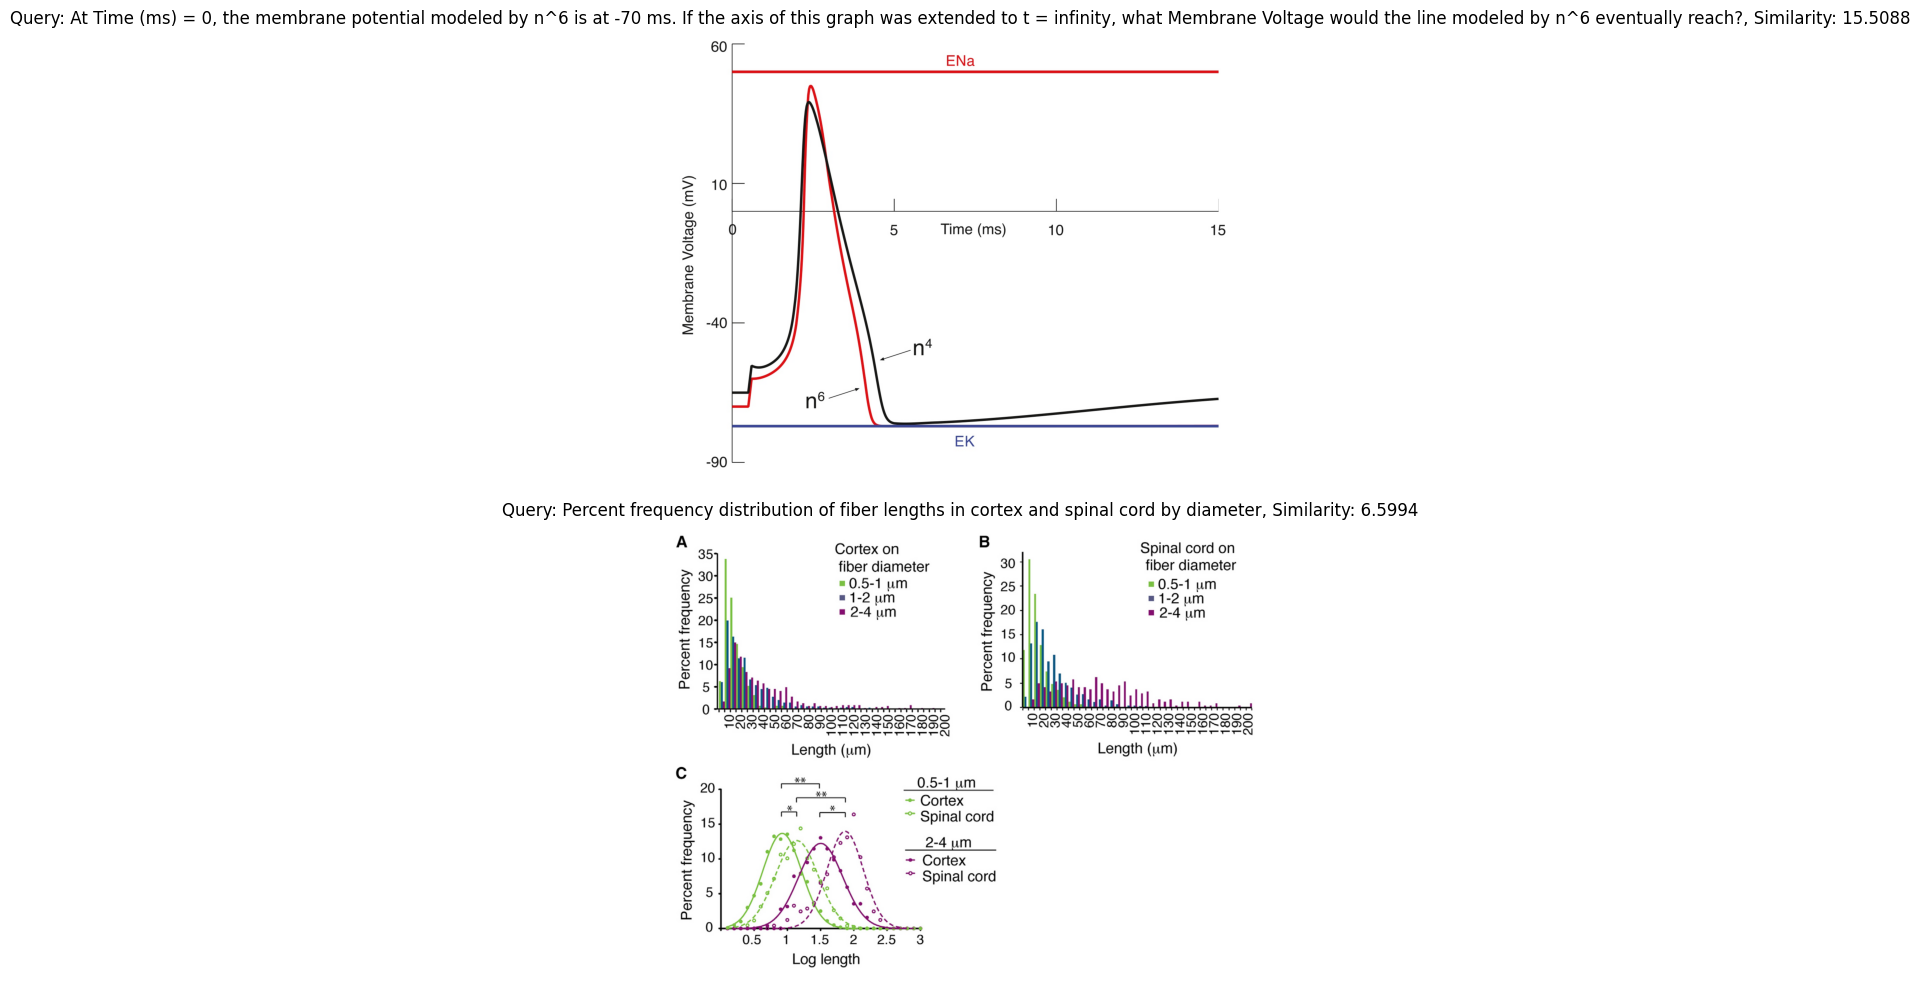

In [24]:
import matplotlib.pyplot as plt
    
num_columns = n_res
num_rows = len(colpali_results)

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))
axes = axes.flatten()  # Flatten for easier access to cells

idx_plot = 0
for res, query in zip(colpali_results, queries):
    for el in res: 
        img = Image.fromarray(el["image"])
        axes[idx_plot].imshow(img)
        axes[idx_plot].set_title(f"Query: {query}, Similarity: {el['score']:.4f}")
        axes[idx_plot].axis('off')  # Turn off axes for a cleaner look
        idx_plot += 1
for ax in axes[len(colpali_results):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

### VQA: Visual Question Answering

The following function, `generate_VQA`, creates a visual question-answering (VQA) system that takes an image and a question, then analyzes the image to provide an answer based on visual cues. 

1. **Convert Image to Base64** : The image (`img`) is encoded to a base64 string, allowing it to be embedded in the API request.
 
2. **System Prompt** : A structured prompt instructs the model to analyze the  image, focusing on visual details that can answer the question.
 
3. **Payload and Headers** : The request payload includes the model (`gpt-4o-mini`), the system prompt, and the base64-encoded image. The model is expected to respond in JSON format, specifically returning an `answer` field with insights based on the image.
 
4. **Send API Request** : Using `requests.post`, the function sends the payload to the OpenAI API. If successful, it parses and returns the answer; otherwise, it returns `False`.

This approach enables an AI-powered visual analysis of images to generate contextually relevant answers.

In [26]:
import json

def generate_VQA(base64_image: str, question:str):

    system_prompt = f"""You are a visual language model specialized in analyzing images. Below is an image provided by the user along with a question. Analyze the image carefully, paying attention to details relevant to the question. Construct a clear and informative answer that directly addresses the user's question, based on visual cues.

    The output must be in JSON format with the following structure:
    {{
        "answer": "The answer to the question based on visual analysis."
    }}

    Here is the question: {question}
    """

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": system_prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
                    },
                ],
            }
        ],
        response_format={"type": "json_object"},
    )

    try:
        
        response = response.choices[0].message.content
        response = json.loads(response)
        answer = response["answer"]
        return answer
    except Exception as e:
        print(f"Error: {e}")
        return False

This code sets `question` to the first item in `queries`, converts the first image in `colpali_results` to an image format, and saves it as `"image.jpg"`.

In [27]:
question = queries[0]
output_image = "image.jpg"
img = Image.fromarray(colpali_results[0]["image"][0])
img.save(output_image)

The following code opens `"image.jpg"` in binary mode, encodes it to a base64 string, and passes it with `question` to the `generate_VQA` function, which returns an answer based on the image.


In [31]:
import base64

with open(output_image, "rb") as image_file:
    base64_image = base64.b64encode(image_file.read()).decode('utf-8')

answer = generate_VQA(base64_image, question)
answer

'As time approaches infinity, the voltage modeled by n^6 will eventually stabilize at the equilibrium potential for potassium (EK), which is represented at approximately -90 mV on the graph.'

We've now gained a solid understanding of multi-modal data processing, advanced retrieval techniques, and hybrid search methods using state-of-the-art models like ColPali. With these skills, you’re equipped to tackle complex, real-world applications that require deep insights from both text and image data. 

Keep experimenting, stay curious, and continue building innovative solutions—this is just the beginning of what’s possible in the field of AI-driven search and information retrieval.

**To learn more about Deep Lake v4, visit the [official blog post](https://www.activeloop.ai/resources/deep-lake-4-0-the-fastest-multi-modal-ai-search-on-data-lakes/) and [documentation](https://docs.deeplake.ai/latest/).**
